# 1. Data Processing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib
import random
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tensorflow as tf;

In [3]:
tf.enable_eager_execution()

In [4]:
# Dataset Parameters - CHANGE HERE
MODE = 'folder' # or 'file', if you choose a plain text file (see above).
# the dataset file or root folder path.
DATASET_PATH = "/Users/shravan/Desktop/DistractionCNN/state-farm-distracted-driver-detection/imgs/train"
TEST_PATH = "/Users/shravan/Desktop/DistractionCNN/state-farm-distracted-driver-detection/imgs/test"
# Image Parameters
N_CLASSES = 10 # CHANGE HERE, total number of classes
IMG_HEIGHT = 200 # CHANGE HERE, the image height to be resized to
IMG_WIDTH = 200 # CHANGE HERE, the image width to be resized to
CHANNELS = 3 # The 3 color channels, change to 1 if grayscale
BATCH_SIZE = 128
imgClassDict = dict({
	"c0": "safe_driving",
	"c1": "texting_right",
	"c2": "talking_on_phone_right",
	"c3": "texting_left",
	"c4": "talking_on_phone_left",
	"c5": "operating_the_radio",
	"c6": "drinking",
	"c7": "reaching_behind",
	"c8": "hair_makeup",
	"c9": "talking_to_passenger",
})
LABELS = [0,1,2,3,4,5,6,7,8,9]
AUTOTUNE = tf.data.experimental.AUTOTUNE
TRAIN_SIZE = None
VALIDATION_SET_SIZE = 2000

In [5]:
imgTest = Image.open(DATASET_PATH+ "/c0/img_52332.jpg")

In [6]:
# safe driving
imgTest.size

(640, 480)

In [7]:
"""
- From a root folder, that will have a sub-folder containing images for each class
    ```
    ROOT_FOLDER
       |-------- SUBFOLDER (CLASS 0)
       |             |
       |             | ----- image1.jpg
       |             | ----- image2.jpg
       |             | ----- etc...
       |             
       |-------- SUBFOLDER (CLASS 1)
       |             |
       |             | ----- image1.jpg
       |             | ----- image2.jpg
       |             | ----- etc...
    ```
"""
# Reading the dataset
# 2 modes: 'file' or 'folder'
def read_images(dataset_path, mode, batch_size):
    imagePaths, labels = list(), list()
    
     # One Hot Encode the labels
    labels_unique = tf.one_hot(LABELS,len(LABELS))
    
    if mode == 'file':
        # Read dataset file
        with open(dataset_path) as f:
            data = f.read().splitlines()
            print(data)
        for d in data:
            imagePaths.append(d.split(' ')[0])
            labels.append(int(d.split(' ')[1]))
    elif mode == 'folder':
        # An ID will be affected to each sub-folders by alphabetical order
        label = 0
        # List the directory
        classes = sorted(os.walk(dataset_path).__next__()[1])
        # List each sub-directory (the classes)
        for c in classes:
            c_dir = os.path.join(dataset_path, c)
            walk = os.walk(c_dir).__next__()
            # Add each image to the training set
            for sample in walk[2]:
                # Only keeps jpeg images
                if sample.endswith('.jpg') or sample.endswith('.jpeg'):
                    imagePaths.append(os.path.join(c_dir, sample))
                    labels.append(labels_unique[int(c[1])])
    else:
        raise Exception("Unknown mode.")

    global TRAIN_SIZE
    TRAIN_SIZE = len(imagePaths)
    
    
    
    def preprocessImage(image):
      image = tf.image.decode_jpeg(image, channels=CHANNELS)
      image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
      image /= 255.0  # normalize to [0,1] range
      return image
    
    def loadImage(path):
      image = tf.read_file(path)
      return preprocessImage(image)
    
    def createTFDataset(datasetPath):
       # Convert to Tensor
      imagePaths = tf.data.Dataset.from_tensor_slices(datasetPath[0])
      labels = tf.data.Dataset.from_tensor_slices(datasetPath[1])

      imageDataset = imagePaths.map(loadImage,
                                    num_parallel_calls = AUTOTUNE)

      dataset = tf.data.Dataset.zip((imageDataset,labels))
      # Running this shuffle overloads my memory so bufferSize is 
      # set low . Not really good but ok for R&D i guess
      dataset = dataset.shuffle(buffer_size=10)
      dataset = dataset.repeat()
      dataset = dataset.batch(batch_size)
      dataset = dataset.prefetch(buffer_size=AUTOTUNE)
      return dataset
      
      
    #Shuffle Paths
    imgWLabelPath = list(zip(imagePaths,labels))
    random.shuffle(imgWLabelPath)
    imagePaths,labels = zip(*imgWLabelPath)
    imagePaths = list(imagePaths)
    labels = list(labels)
    
    # couldn't split the dataset using tf core api
    # but this way is 'okay' IMO
    devSet = [imagePaths[:VALIDATION_SET_SIZE],labels[:VALIDATION_SET_SIZE]]
    trainSet = [imagePaths[VALIDATION_SET_SIZE:],labels[VALIDATION_SET_SIZE:]]
    
    trainDataset = createTFDataset(trainSet)
    devDataset = createTFDataset(devSet)
    
    
    return trainDataset,devDataset

In [8]:
train_ds,validation_ds = read_images(DATASET_PATH,MODE,BATCH_SIZE);

tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


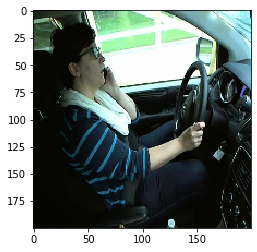

In [9]:
X_train,Y_train = next(iter(train_ds))
plt.imshow(X_train[-2])
print(Y_train[-2])

# 2. Loading Pre trained model

## VGGNet

In [10]:
vggNet = tf.keras.applications.VGG16(
    input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNELS),
    include_top = False,
    weights = 'imagenet'
)
vggNet.trainable = False

In [11]:
myModel = tf.keras.Sequential([
    vggNet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(LABELS),activation=tf.nn.softmax)
])

In [12]:
myModel.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-4),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["accuracy"])

In [13]:
myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 14,719,818
Trainable params: 5,130
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
import os
# include the epoch in the file name. (uses `str.format`)
checkpoint_path = "checkpoint_trainingVGG/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
try:
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    myModel.load_weights(latest)
    print('Weights loaded succesfully!...')
except:
    print('Loading unsuccesful. Proceeding to normal training...')
    pass

Weights loaded succesfully!...


In [16]:
X_val,Y_val = next(iter(validation_ds))
t = myModel.evaluate(X_val,Y_val)

 64/128 [==============>...............] - ETA: 20s - loss: 1.0508 - acc: 0.7969

KeyboardInterrupt: 

In [ ]:
y_pred = myModel.predict_classes(X_val)

In [52]:
X_val[0]

<tf.Tensor: id=271377, shape=(200, 200, 3), dtype=float32, numpy=
array([[[0.07058824, 0.09411765, 0.05490196],
        [0.06509804, 0.08862745, 0.04941177],
        [0.07137255, 0.1027451 , 0.05960784],
        ...,
        [0.8188237 , 0.99529433, 0.83450997],
        [0.8666674 , 1.        , 0.8784321 ],
        [0.90039206, 1.        , 0.8980392 ]],

       [[0.07058824, 0.08235294, 0.04705882],
        [0.06321569, 0.08674509, 0.04752941],
        [0.06039216, 0.0917647 , 0.04862745],
        ...,
        [0.75278443, 0.92925507, 0.7684707 ],
        [0.81819683, 0.9656476 , 0.82196134],
        [0.87764686, 0.9876078 , 0.8650979 ]],

       [[0.07372548, 0.08549019, 0.05019608],
        [0.08094118, 0.09505882, 0.05898039],
        [0.06039216, 0.08392157, 0.04470588],
        ...,
        [0.7203138 , 0.8967844 , 0.73976463],
        [0.7590595 , 0.91968673, 0.7595297 ],
        [0.8205487 , 0.94666654, 0.7902744 ]],

       ...,

       [[0.03529412, 0.03921569, 0.01568628],
  

In [39]:
y_real = tf.argmax(Y_val,axis=1)

In [40]:
con_mat = tf.math.confusion_matrix(labels=y_real, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = [i for i in imgClassDict.values()], 
                     columns = [i for i in imgClassDict.values()])

In [41]:
con_mat_df

,safe_driving,texting_right,talking_on_phone_right,texting_left,talking_on_phone_left,operating_the_radio,drinking,reaching_behind,hair_makeup,talking_to_passenger
safe_driving,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
texting_right,0.00,0.80,0.07,0.00,0.00,0.00,0.13,0.0,0.00,0.00
talking_on_phone_right,0.00,0.00,0.92,0.00,0.00,0.08,0.00,0.0,0.00,0.00
texting_left,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.0,0.00,0.00
talking_on_phone_left,0.00,0.11,0.00,0.00,0.78,0.00,0.11,0.0,0.00,0.00
operating_the_radio,0.00,0.00,0.00,0.00,0.06,0.94,0.00,0.0,0.00,0.00
drinking,0.00,0.07,0.00,0.00,0.00,0.07,0.80,0.0,0.07,0.00
reaching_behind,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00
hair_makeup,0.12,0.00,0.00,0.12,0.12,0.00,0.25,0.0,0.38,0.00
talking_to_passenger,0.31,0.00,0.00,0.00,0.08,0.00,0.00,0.0,0.08,0.54


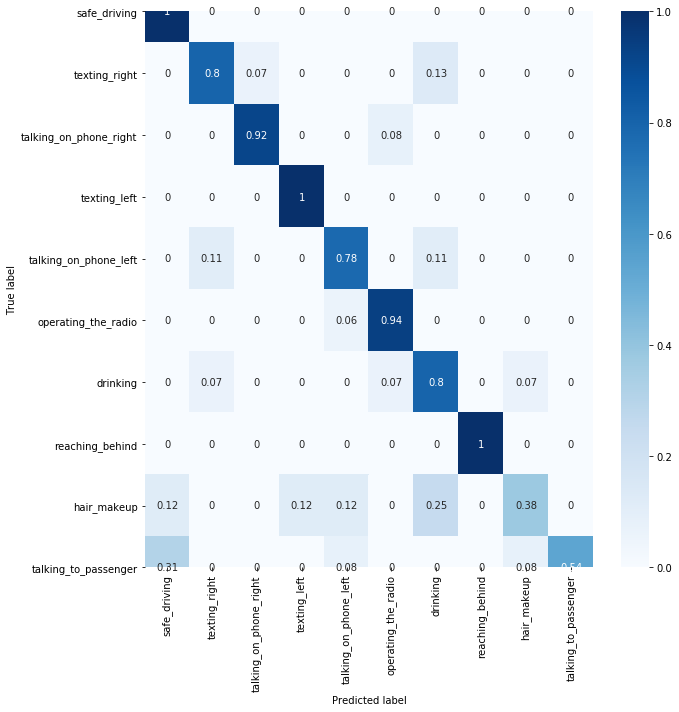

In [42]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [18]:
# myModel.save_weights(checkpoint_path.format(epoch=0))

In [19]:
# myModel.fit(train_ds,epochs=3,steps_per_epoch=TRAIN_SIZE-VALIDATION_SET_SIZE,
#              validation_data=validation_ds,validation_steps=VALIDATION_SET_SIZE,
#            callbacks = [cp_callback])

Epoch 1/3


W0827 11:30:55.064570 140176626812672 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


20423/20424 [============================>.] - ETA: 0s - loss: 1.7779 - acc: 0.4280
Epoch 00001: saving model to checkpoint_trainingVGG/cp-0001.ckpt
20424/20424 [==============================] - 20406s 999ms/step - loss: 1.7779 - acc: 0.4280 - val_loss: 1.3363 - val_acc: 0.7670
Epoch 2/3
20423/20424 [============================>.] - ETA: 0s - loss: 1.4258 - acc: 0.5437
Epoch 00002: saving model to checkpoint_trainingVGG/cp-0002.ckpt
20424/20424 [==============================] - 20402s 999ms/step - loss: 1.4257 - acc: 0.5437 - val_loss: 1.0881 - val_acc: 0.8195
Epoch 3/3
20423/20424 [============================>.] - ETA: 0s - loss: 1.3161 - acc: 0.5726
Epoch 00003: saving model to checkpoint_trainingVGG/cp-0003.ckpt
20424/20424 [==============================] - 20389s 998ms/step - loss: 1.3161 - acc: 0.5726 - val_loss: 0.9663 - val_acc: 0.8415


In [45]:
r = myModel.predict_classes(tf.expand_dims(X_train[0],0))

In [50]:
imgClassDict['c'+ str(r[0])]

'safe_driving'

# Testing with test set

In [47]:
def preprocessImage(image):
  image = tf.image.decode_jpeg(image, channels=CHANNELS)
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
#   image /= 255.0  # normalize to [0,1] range
  return image

In [48]:
imgTest = preprocessImage(tf.read_file(TEST_PATH+ "/img_90.jpg"))

In [43]:
r = myModel.predict_classes(tf.expand_dims(imgTest,0))
imgClassDict['c'+ str(r[0])]

'talking_to_passenger'

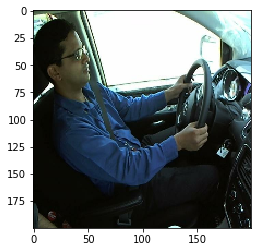

In [45]:
plt.imshow(imgTest)

In [52]:
imgTest

<tf.Tensor: id=91080, shape=(200, 200, 3), dtype=float32, numpy=
array([[[ 70.       ,  74.       ,  59.       ],
        [ 69.8      ,  74.4      ,  59.2      ],
        [ 68.       ,  77.       ,  60.       ],
        ...,
        [243.       , 255.       , 255.       ],
        [250.60004  , 255.       , 254.39996  ],
        [255.       , 251.20001  , 251.       ]],

       [[ 67.6      ,  80.8      ,  60.4      ],
        [ 67.28     ,  82.28     ,  61.48     ],
        [ 68.       ,  84.36     ,  62.96     ],
        ...,
        [239.00003  , 254.51999  , 253.76001  ],
        [246.12009  , 254.75998  , 253.47995  ],
        [252.51999  , 252.52     , 252.6      ]],

       [[ 69.4      ,  89.       ,  64.2      ],
        [ 70.6      ,  93.       ,  67.2      ],
        [ 72.68     ,  96.       ,  70.       ],
        ...,
        [233.6      , 255.       , 252.2      ],
        [237.68007  , 254.51997  , 251.83994  ],
        [244.51999  , 254.16     , 253.16     ]],

       .